Loading file: /Users/olayinkaajao/Downloads/ATLAS_2/Training/R039/sub-r039s002/ses-1/anat/sub-r039s002_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz
Loading file: /Users/olayinkaajao/Downloads/ATLAS_2/Training/R039/sub-r039s002/ses-1/anat/sub-r039s002_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz
Loading file: /Users/olayinkaajao/Downloads/ATLAS_2/Training/R039/sub-r039s003/ses-1/anat/sub-r039s003_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz
Loading file: /Users/olayinkaajao/Downloads/ATLAS_2/Training/R039/sub-r039s003/ses-1/anat/sub-r039s003_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz
Loading file: /Users/olayinkaajao/Downloads/ATLAS_2/Training/R001/sub-r001s016/ses-1/anat/sub-r001s016_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz
Loading file: /Users/olayinkaajao/Downloads/ATLAS_2/Training/R001/sub-r001s016/ses-1/anat/sub-r001s016_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz
Loading file: /Users/olayinkaajao/Downloads/ATLAS_2/Training/

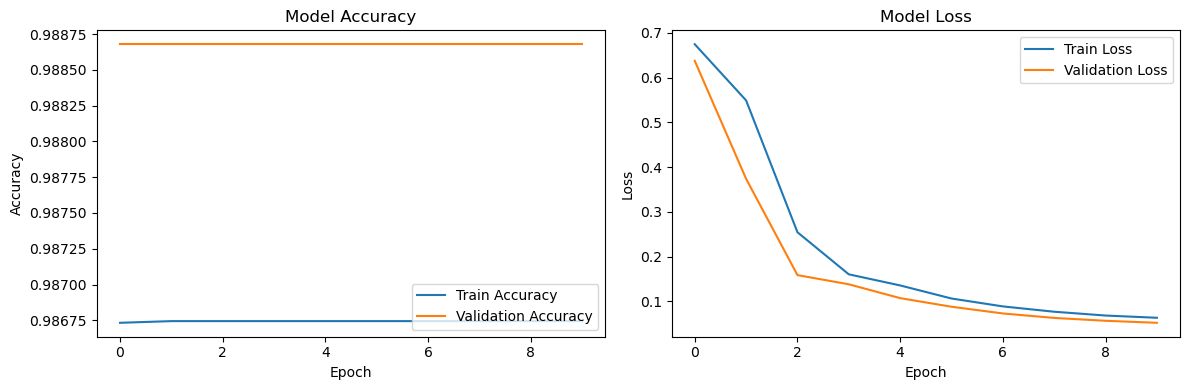

In [14]:
import nibabel as nib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os
import glob

# Step 1: Load NIfTI Files

# Function to load the NIfTI image using glob to match file patterns
def load_nifti_image(subject_dir, filename_pattern):
    """Load a NIfTI file matching the filename pattern from the subject directory."""
    # Use glob to find the file matching the pattern
    file_list = glob.glob(os.path.join(subject_dir, filename_pattern))
    
    if len(file_list) == 0:
        raise FileNotFoundError(f"No files found matching {filename_pattern} in {subject_dir}")
    
    # Load the first matched file
    print(f"Loading file: {file_list[0]}")
    img = nib.load(file_list[0])
    return img.get_fdata()

# Function to preprocess images (normalization, resizing, extracting slice)
def preprocess_image(image_data, target_size=(128, 128)):
    """Normalize and resize the image data."""
    # Normalize the image data to [0, 1]
    image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
    
    # Extract the middle slice along the z-axis (for simplicity)
    middle_slice = image_data[:, :, image_data.shape[2] // 2]
    
    # Resize to target size (128x128)
    resized_image = tf.image.resize(middle_slice[..., np.newaxis], target_size)
    return resized_image

# Directory where the 'Training' folder is stored
data_dir1 = '/Users/olayinkaajao/Downloads/ATLAS_2/'

# Step 2: Use glob to find R0* folders inside the 'Training' folder
r0_dirs = glob.glob(os.path.join(data_dir1, 'Training', 'R0*'))

# Initialize arrays to store images and masks
X = []
y = []

# Step 3: Iterate through each R0* folder and subject sub-folders
for r0_dir in r0_dirs:
    # For each R0* directory, list the subject directories
    subject_dirs = [os.path.join(r0_dir, d) for d in os.listdir(r0_dir) if os.path.isdir(os.path.join(r0_dir, d))]
    
    for subject_dir in subject_dirs:
        anat_dir = os.path.join(subject_dir, 'ses-1', 'anat')
        
        # Load the T1-weighted image and lesion mask
        t1_data = load_nifti_image(anat_dir, 'sub-*_T1w.nii.gz')
        lesion_mask_data = load_nifti_image(anat_dir, 'sub-*_label-L_desc-T1lesion_mask.nii.gz')

        # Preprocess the images (normalize, resize, and take middle slice)
        t1_preprocessed = preprocess_image(t1_data)
        lesion_mask_preprocessed = preprocess_image(lesion_mask_data)

        # Append to the dataset (add both input image and corresponding mask)
        X.append(t1_preprocessed.numpy())
        y.append(lesion_mask_preprocessed.numpy())

# Convert the list to numpy arrays for training
X = np.array(X)
y = np.array(y)

# Check the size of X and y after loading and preprocessing
print(f"Loaded {len(X)} images and {len(y)} masks.")

# Ensure the dataset is not empty
if len(X) == 0 or len(y) == 0:
    raise ValueError("No data loaded. Please check the data paths and ensure files are present.")

# Step 4: Split Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Define a Model-Building Function for Keras Tuner
def build_cnn_model(hp):
    """Build a CNN model with hyperparameter tuning."""
    model = models.Sequential()

    # First Conv2D Layer with tunable filters
    model.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3), 
        activation='relu', 
        padding='same', 
        input_shape=(128, 128, 1)  # Fixed input shape
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv2D Layer with tunable filters
    model.add(layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Conv2D Layer with tunable filters
    model.add(layers.Conv2D(
        filters=hp.Int('filters_3', min_value=128, max_value=512, step=128),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Upsampling layers to increase back to the original image size
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'))

    # Final layer for output (binary segmentation mask)
    model.add(layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'))

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Step 6: Set Up Random Search with Keras Tuner
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per trial
    directory='my_dir',
    project_name='cnn_tuning'
)

# Step 7: Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Step 8: Get the Best Model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters: ", best_hyperparameters.values)

# Step 9: Train the Best Model
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2)


# Optional: Save the trained model
best_model.save('stroke_detection_cnn_model.h5')
# Step 10: Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


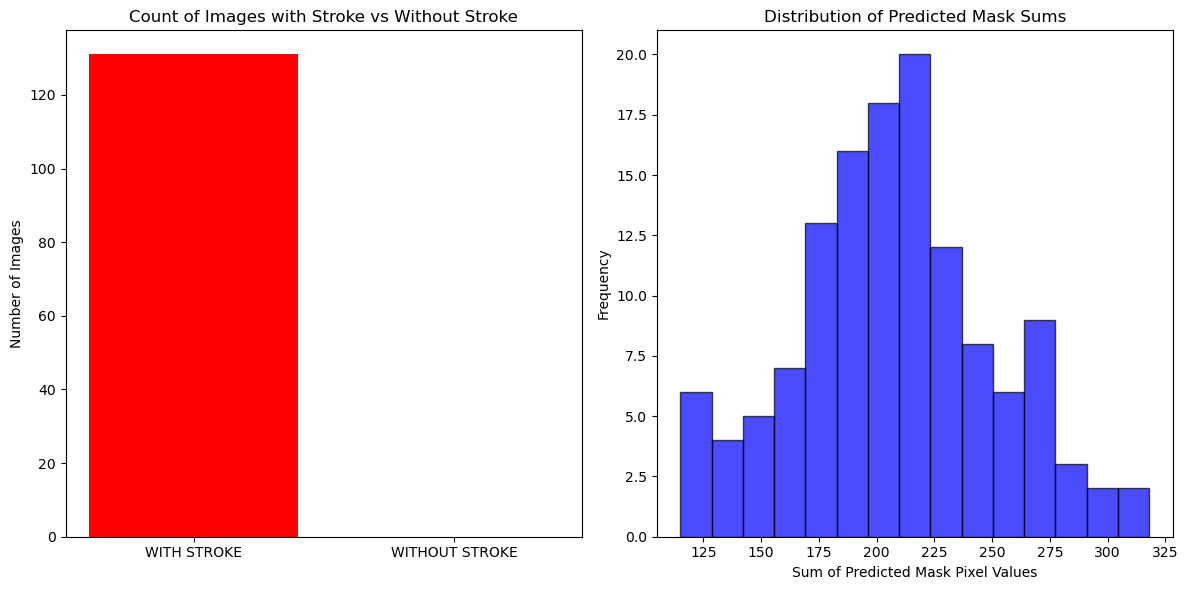

Number of images WITH STROKE: 131
Number of images WITHOUT STROKE: 0

Statistical Analysis of Predicted Mask Sums:
Mean sum of predicted mask pixel values: 208.30
Median sum of predicted mask pixel values: 208.82
Standard deviation of predicted mask pixel values: 43.48

Shapiro-Wilk Normality Test: p-value = 0.3244
The distribution of predicted mask sums is likely normal.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Function to classify stroke and non-stroke predictions
def classify_predictions(model, X_test, stroke_threshold=20):
    """Classify all predictions in the test set as WITH STROKE or WITHOUT STROKE."""
    predictions = model.predict(X_test)
    
    stroke_count = 0
    non_stroke_count = 0
    pred_sums = []  # List to hold sum of pixel values for all predicted masks
    
    # Classify each test sample based on the sum of predicted mask pixel values
    for i in range(len(predictions)):
        pred_sum = np.sum(predictions[i])
        pred_sums.append(pred_sum)  # Collect the sum of pixel values
        if pred_sum > stroke_threshold:
            stroke_count += 1  # Classified as stroke
        else:
            non_stroke_count += 1  # Classified as non-stroke

    return stroke_count, non_stroke_count, np.array(pred_sums)


# Function to plot the count of stroke and non-stroke images and show feature plots
def plot_stroke_vs_non_stroke(model, X_test, stroke_threshold=20):
    """Plot the number of stroke vs non-stroke images and feature plots."""
    
    # Get the count of stroke and non-stroke predictions and the sum of pixel values
    stroke_count, non_stroke_count, pred_sums = classify_predictions(model, X_test, stroke_threshold)
    
    # Plot the counts in a bar chart
    labels = ['WITH STROKE', 'WITHOUT STROKE']
    counts = [stroke_count, non_stroke_count]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(labels, counts, color=['red', 'green'])
    plt.title('Count of Images with Stroke vs Without Stroke')
    plt.ylabel('Number of Images')

    # Feature Plot: Histogram of the sum of predicted mask pixel values
    plt.subplot(1, 2, 2)
    plt.hist(pred_sums, bins=15, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Predicted Mask Sums')
    plt.xlabel('Sum of Predicted Mask Pixel Values')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Print the counts
    print(f"Number of images WITH STROKE: {stroke_count}")
    print(f"Number of images WITHOUT STROKE: {non_stroke_count}")

    # Perform statistical analysis on predicted mask sums
    mean_pred_sum = np.mean(pred_sums)
    median_pred_sum = np.median(pred_sums)
    std_pred_sum = np.std(pred_sums)

    print("\nStatistical Analysis of Predicted Mask Sums:")
    print(f"Mean sum of predicted mask pixel values: {mean_pred_sum:.2f}")
    print(f"Median sum of predicted mask pixel values: {median_pred_sum:.2f}")
    print(f"Standard deviation of predicted mask pixel values: {std_pred_sum:.2f}")
    
    # Optional: Perform normality test (Shapiro-Wilk test) if there are at least 3 data points
    if len(pred_sums) >= 3:
        stat, p_value = stats.shapiro(pred_sums)
        print(f"\nShapiro-Wilk Normality Test: p-value = {p_value:.4f}")
        if p_value > 0.05:
            print("The distribution of predicted mask sums is likely normal.")
        else:
            print("The distribution of predicted mask sums is likely not normal.")
    else:
        print("\nNot enough data for Shapiro-Wilk normality test (requires at least 3 samples).")


# Example usage
plot_stroke_vs_non_stroke(best_model, X_test, stroke_threshold=20)

Number of test samples: 131
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


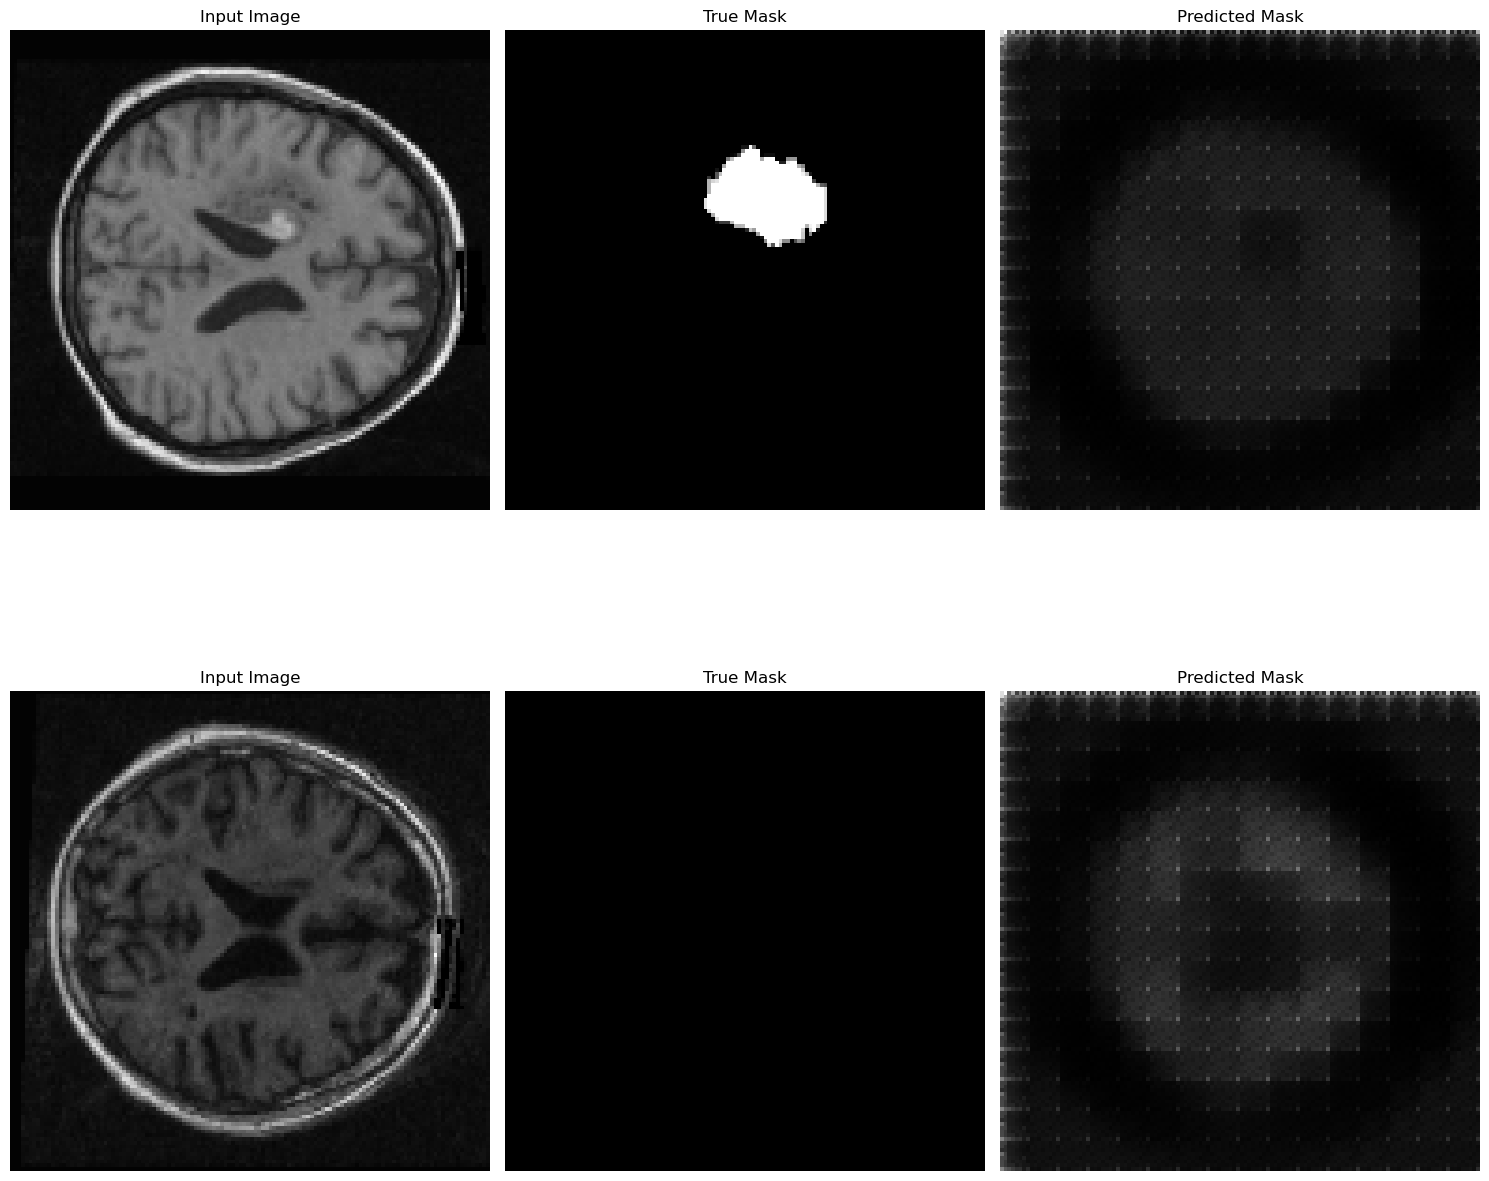

In [18]:
import matplotlib.pyplot as plt

# Function to create a matrix of images with predicted stroke masks
def visualize_predictions_matrix(model, X_test, y_test, num_samples=9):
    """Visualize a matrix of input images, true masks, and predicted masks."""
    
    # Ensure num_samples does not exceed the available samples
    num_samples = min(num_samples, X_test.shape[0])
    
    # Generate predictions for the test set
    predictions = model.predict(X_test)
    
    plt.figure(figsize=(15, 15))  # Adjust the figure size depending on the number of samples

    for i in range(num_samples):
        # Input image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X_test[i, :, :, 0], cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        # True Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_test[i, :, :, 0], cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Check the size of X_test
print(f"Number of test samples: {X_test.shape[0]}")

# Visualize a matrix of images, make sure num_samples <= size of X_test
visualize_predictions_matrix(best_model, X_test, y_test, num_samples=2)


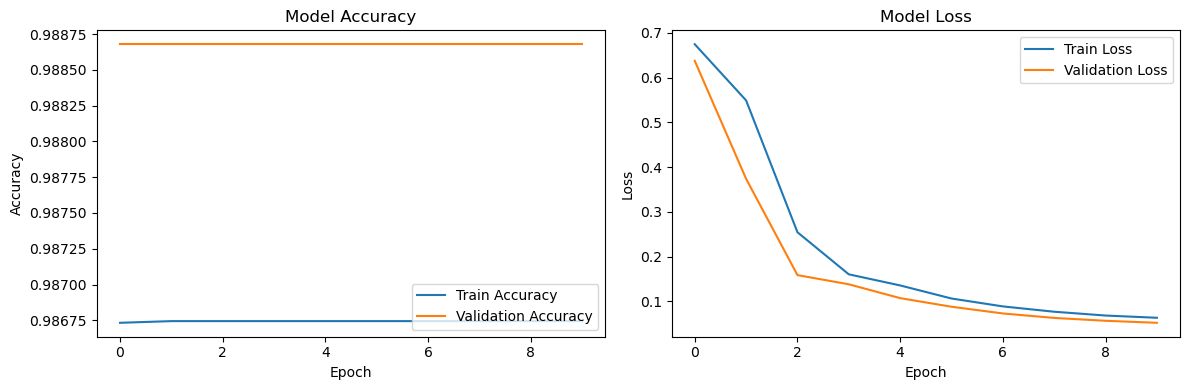

In [22]:
# Step 1: Plot training & validation accuracy values
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
pip install streamlit